In [52]:
# Import the necessary modules
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from data_plugin_for_julio import get_bigb_data

bigb_df = get_bigb_data()[0]

In [36]:
bigb_df

,open,high,low,close,adjclose,volume,actual_returns
date,,,,,,,
2003-04-21,100.825001,101.158335,98.689999,99.275833,64.360246,5.579605e+06,NaN
2003-04-22,98.722499,102.411667,98.139999,102.307500,66.318688,8.367843e+06,0.030538
2003-04-23,102.270832,103.690000,101.524169,103.319999,66.945524,8.174293e+06,0.009897
2003-04-24,102.003335,102.538332,100.073335,100.773333,65.307015,6.983018e+06,-0.024648
2003-04-25,100.783335,101.002499,98.405831,98.890000,64.106827,6.061628e+06,-0.018689
...,...,...,...,...,...,...,...
2023-04-06,106.985001,108.005002,106.708336,107.610000,107.610000,1.509477e+07,0.003731
2023-04-10,107.341666,108.524997,106.998333,108.323332,108.323332,1.602218e+07,0.006629
2023-04-11,108.683332,109.926669,108.100002,109.376666,109.376666,1.928543e+07,0.009724


In [37]:
print(bigb_df.columns)


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'actual_returns'], dtype='object')


In [38]:
print(bigb_df.index.name)


date


# Seasonal Closing Price

In [39]:
quarterly_close_prices = bigb_df.resample('Q').mean()
quarterly_close_prices['Year'] = quarterly_close_prices.index.year
quarterly_close_prices['Quarter'] = quarterly_close_prices.index.quarter

# Plot the heatmap
heatmap = quarterly_close_prices.hvplot.heatmap(
    x="Year",
    y="Quarter",
    C="close",
    cmap="blues",
    width=800,
    height=400,
    colorbar=True,
    title="BIGB Quarterly Close Price per Year Heatmap"
)
# Save the elbow plot as a PNG file in the "images" directory
file_path = 'images/heatmap.png'
hvplot.save(heatmap, file_path, fmt='png')
heatmap

:HeatMap   [Year,Quarter]   (close)

# Prophet 

In [40]:
# Prepare the data for Prophet
prophet_data = bigb_df.reset_index()[['date', 'close']]
prophet_data.columns = ['ds', 'y']

00:37:18 - cmdstanpy - INFO - Chain [1] start processing
00:37:20 - cmdstanpy - INFO - Chain [1] done processing


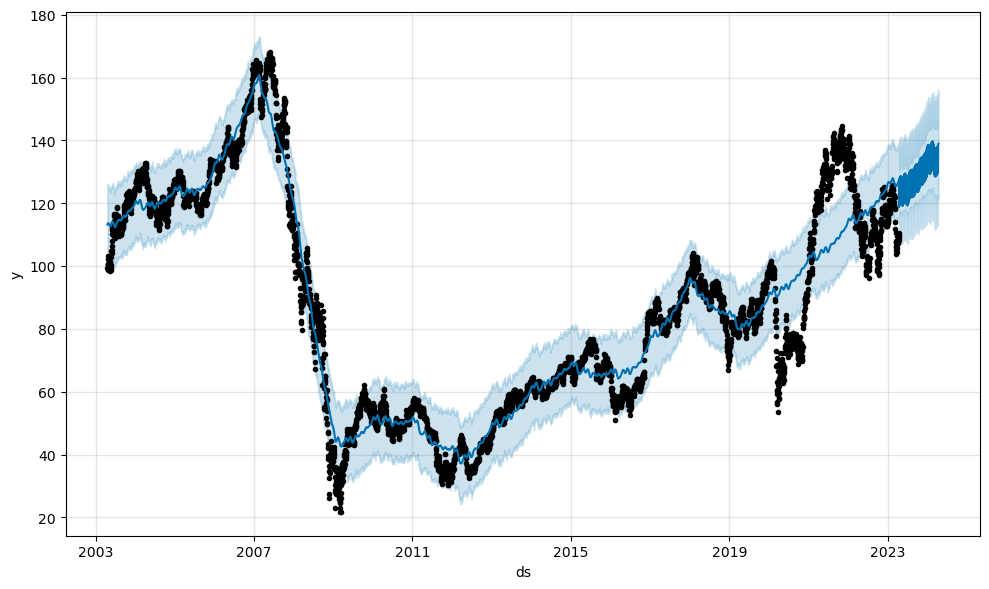

In [65]:
# Fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make predictions
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

# Prophet plot
prophet_fig = prophet_model.plot(forecast)
prophet_ax = prophet_fig.gca()

# Save the Prophet plot
prophet_fig.savefig('images/prophet_plot.png')

# Prepare the data for SARIMA and ARIMA

In [49]:
# Prepare the data for SARIMA and ARIMA
sarima_data = bigb_df['close']

# SARIMA

/Users/rodvilla/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodvilla/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98365D+00    |proj g|=  1.93528D-01

At iterate    5    f=  1.87321D+00    |proj g|=  3.69956D-02

At iterate   10    f=  1.85548D+00    |proj g|=  2.52333D-03

At iterate   15    f=  1.85456D+00    |proj g|=  2.77778D-03

At iterate   20    f=  1.85455D+00    |proj g|=  2.06329D-04

At iterate   25    f=  1.85454D+00    |proj g|=  1.25363D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

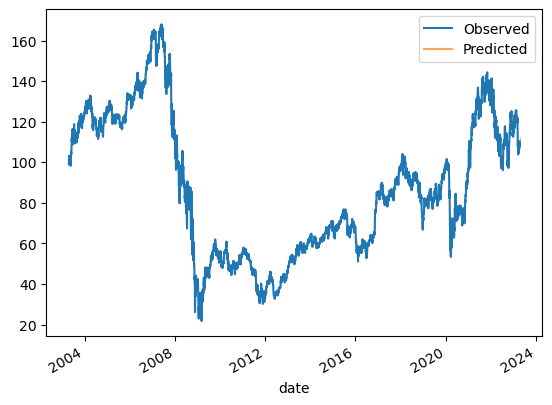

In [70]:
# Fit the model
sarima_model = SARIMAX(sarima_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

# Make predictions
sarima_pred = sarima_results.get_prediction(start=pd.to_datetime('2023-04-13'), dynamic=False)
sarima_pred_conf = sarima_pred.conf_int()

# SARIMA plot
sarima_plot = sarima_data.plot(label='Observed')
sarima_pred.predicted_mean.plot(ax=sarima_plot, label='Predicted', alpha=0.7)
sarima_plot.fill_between(sarima_pred_conf.index,
                         sarima_pred_conf.iloc[:, 0],
                         sarima_pred_conf.iloc[:, 1], color='k', alpha=0.2)
sarima_plot.legend()

# Save the SARIMA plot
sarima_plot.figure.savefig('images/sarima_plot.png')

# ARIMA

/Users/rodvilla/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodvilla/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodvilla/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


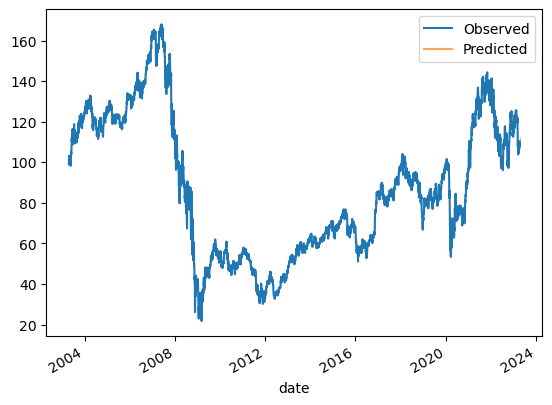

In [71]:
# Fit the model
arima_model = ARIMA(sarima_data, order=(1, 1, 1))
arima_results = arima_model.fit()

# Make predictions
arima_pred = arima_results.get_prediction(start=pd.to_datetime('2023-04-13'), dynamic=False)
arima_pred_conf = arima_pred.conf_int()

# Plot the predictions
arima_plot = sarima_data.plot(label='Observed')
arima_pred.predicted_mean.plot(ax=arima_plot, label='Predicted', alpha=0.7)
arima_plot.fill_between(arima_pred_conf.index,
                        arima_pred_conf.iloc[:, 0],
                        arima_pred_conf.iloc[:, 1], color='k', alpha=0.2)
arima_plot.legend()

# Save the ARIMA plot
arima_plot.figure.savefig('images/arima_plot.png')


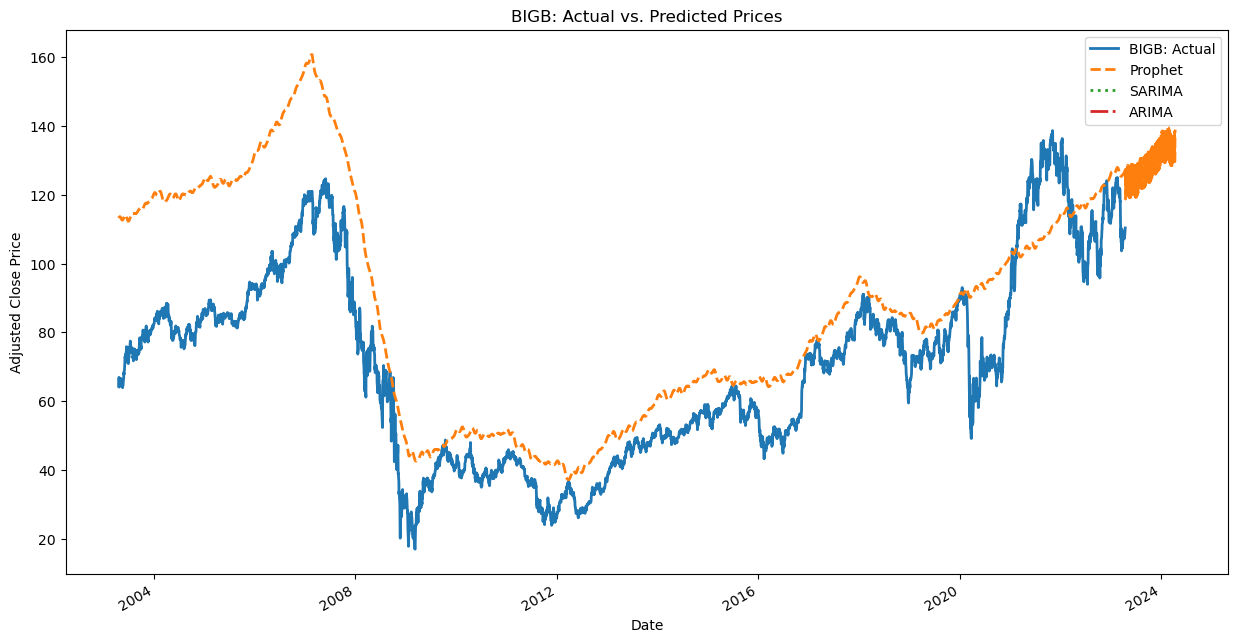

In [72]:
# Convert Prophet predictions to DataFrame
prophet_pred_df = forecast.set_index('ds')[['yhat']].rename(columns={'yhat': 'Prophet'})

# Convert SARIMA and ARIMA predictions to DataFrame
sarima_pred_df = sarima_pred.predicted_mean.to_frame().rename(columns={0: "SARIMA"})
arima_pred_df = arima_pred.predicted_mean.to_frame().rename(columns={0: "ARIMA"})

# Merge predictions DataFrames
predictions_df = pd.concat([prophet_pred_df, sarima_pred_df, arima_pred_df], axis=1)

# Plot the actual values, Prophet, SARIMA, and ARIMA predictions
fig, ax = plt.subplots(figsize=(15, 8))
bigb_df['adjclose'].plot(ax=ax, label='BIGB: Actual', linewidth=2)
predictions_df['Prophet'].plot(ax=ax, label='Prophet', linestyle='--', linewidth=2)
predictions_df['SARIMA'].plot(ax=ax, label='SARIMA', linestyle=':', linewidth=2)
predictions_df['ARIMA'].plot(ax=ax, label='ARIMA', linestyle='-.', linewidth=2)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('BIGB: Actual vs. Predicted Prices')
plt.show()
fig.savefig('images/combined_plot.png')